In [33]:
import pickle
from universal.algos import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from universal import tools
from universal import result
from itertools import chain
from PPO import PPO
from torch.distributions import Categorical
from env.Portfolio_management import CustomEnv
import seaborn as sns
EPISODES = 1000
lr = 0.001
gamma = 0.98
lmbda = 0.95
epochs = 3
eps_clip = 0.2
MAX_STEPS = 2835

In [152]:
df = pd.read_csv('./Stock Market/DAX_close.csv')
df_original_train = df.head(round(0.8*len(df)))
df_original_test = df.tail(round(0.2*len(df)))

df_ob = pd.read_csv('./Stock Market/DAX_final.csv')
df_ob_train = df_ob.head(round(0.8 * len(df_ob)))
df_ob_test = df_ob.tail(round(0.2 * len(df_ob)))
train_set = (df_ob_train - np.mean(df_ob_train.to_numpy())) / np.std(df_ob_train.to_numpy())
test_set = (df_ob_test - np.mean(df_ob_train.to_numpy())) / np.std(df_ob_train.to_numpy())

In [205]:

train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)

#model = PPO(1500, 15)
pkl_file = open('model/dax.pkl', 'rb')
model = pickle.load(pkl_file)
model.train()
n_epi =0
total_reward = []
total_test_reward = []
total_portfolio_wealth = []
stock_weight = []
stock_weight = pd.DataFrame(stock_weight)
total_step_test = len(test_set)//10 - 2

In [207]:
env = CustomEnv(df_original_train,train_set)
s = env.reset()  # observation
done = False
t = 0
test_reward_list = 0
n_epi +=1
h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))

test_action_list = []
punishment = 0
s = np.append(s, punishment)
a = 0
done = False
t = 0
my_total_wealth = 1
reward_list = 0
while (done == False):
    t = t + 1
    h_in = h_out
    #s = s.to_numpy()
    prob, h_out = model.pi(torch.from_numpy(s.reshape(-1)).float(), h_in)
    prob = prob.view(-1)
    np_array= prob.detach().numpy()
    #print(prob)
    count = np_array.shape[0]
    for i in range(count):
         if np_array[i] == np_array.max():
            action = i
            break;
    
    print(action)
    next_s, r, done, _, result = env.step(action)    

    my_total_wealth = my_total_wealth * result.total_wealth
    #print(result.total_wealth)
    total_portfolio_wealth.append(my_total_wealth)
    test_reward_list = test_reward_list + r
    a=a+1
    test_action_list.append(action)
    test_action_counter = max(np.bincount(test_action_list))
    test_most_action = np.argmax(np.bincount(test_action_list))

    if action == test_most_action and test_action_counter > total_step_test // 3:
        punishment = 1
        s[len(s) - 1] = punishment
    else:
        punishment = 0
        s[len(s) - 1] = punishment
    next_s = np.append(next_s, punishment)
    
    stock_weight = stock_weight.append(result.B)
   
    s = next_s
    if done:
        break


8
1.0511000392734606
8
1.0701385862174788
8
1.0178336960599572
8
0.9633208221734691
8
1.0503085618721877
8
1.0457177478498079
8
1.0281170280044207
8
1.018137227518355
8
1.061257786065634
8
1.0259095369255344
8
1.0189548837702942
8
1.0173229572983913
8
0.9924811562888873
8
1.0174090580300856
8
0.9997302903853681
8
1.0321126167054402
8
1.0093501821137427
8
1.011406287760195
8
1.0303539248904428
8
1.061385059767324
8
0.980225728752103
8
1.045265568801636
8
1.0735147694369187
8
1.0395226548908991
8
1.0101984242645101
8
0.9840271267505761
8
1.0480049880345663
8
1.0633743739780812
8
1.0460328138826138
8
0.9950074211172578
8
1.048033108636241
8
1.149772171519912
8
1.060419204180046
8
0.9972951823004313
8
1.0082661946506644
8
0.9772580061668668
8
0.9818757227512386
8
0.9478802755486303
8
1.080077826984838
8
0.9736985775812462
8
1.0279900617023396
8
1.018112815521606
8
1.0012682782111877
8
1.09732529954998
8
0.9821148417245307
8
1.039623507789103
8
0.9852812723593144
8
0.9378882072714536
8
1.07

In [158]:
print(a)

46


In [159]:
print(my_total_wealth)

1.1888048787636747


In [160]:
stock_weight

,close,close.1,close.2,close.3,close.4,close.5,close.6,close.7,close.8,close.9,...,close.24,close.25,close.26,close.27,close.28,close.29,close.30,close.31,close.32,close.33
1956,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
1957,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
1958,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
1959,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
1960,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,...,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
2412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [183]:
sp_data = pd.read_csv('./Stock Market/DAX_close.csv')
test_set = sp_data.tail(round(0.2*len(sp_data)))
test_set

,close,close.1,close.2,close.3,close.4,close.5,close.6,close.7,close.8,close.9,...,close.24,close.25,close.26,close.27,close.28,close.29,close.30,close.31,close.32,close.33
1946,276.854830,74.817985,210.734966,56.561359,67.392759,118.626814,118.980396,95.010003,61.876878,102.185244,...,268.133136,59.519663,78.613100,50.079020,37.668286,159.041255,130.141806,381.868731,124.991293,153.289652
1947,276.834993,72.798229,208.367873,55.295802,66.556686,119.847125,120.025116,91.638893,62.320505,96.471003,...,266.036886,57.075710,77.865033,50.205266,37.828974,158.411794,127.037953,393.478284,125.780151,147.139045
1948,280.909051,75.030737,213.731053,56.864657,69.226539,120.910979,121.087577,94.136308,61.220749,100.237203,...,275.493370,60.137612,78.103548,49.412208,38.580845,162.446902,132.166178,387.809897,127.621715,154.794309
1949,276.818690,76.756945,213.156268,56.421644,67.153511,120.366173,120.189856,97.045481,62.957151,101.676504,...,271.764251,61.217483,75.816584,47.288390,38.331454,159.602725,130.028380,375.909202,125.479385,157.604458
1950,281.358619,79.297339,213.568187,57.829582,66.692851,120.734005,121.383112,93.795471,63.588936,99.773732,...,274.631504,61.936662,77.940114,47.030793,38.934651,160.553803,132.299921,375.066146,126.871022,158.948737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,180.315426,108.189255,178.112477,44.023277,58.551519,101.376433,101.723193,79.193964,67.332717,72.840089,...,224.476387,69.331689,71.187877,47.169618,38.806572,91.299983,105.904716,411.319068,110.912345,135.093786
2428,170.195998,107.330809,177.371829,43.080542,58.878615,103.088687,103.037577,77.380402,66.974425,70.429455,...,224.781380,68.875714,69.182373,47.828653,39.047971,90.975638,105.184193,407.857075,112.850679,134.214621
2429,163.443332,103.152704,177.305110,42.760748,58.122192,103.507355,101.784765,77.891438,66.147431,67.809224,...,223.531302,68.336133,65.742116,47.097620,40.014738,90.354878,106.233099,412.610816,111.512329,133.855326
2430,167.237721,103.031657,177.622495,43.717046,58.095573,102.368582,102.470593,79.824031,66.797157,69.286239,...,223.099240,71.652906,65.899456,49.424592,40.753611,91.453347,108.642291,417.227203,114.354938,138.715294


In [184]:
wealth = 1
CRP_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = CRP()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        CRP_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.013867283955473
1.0067026660462601
0.9536641522477418
1.0249816494682278
0.9299215118929656
1.1330420698813182
1.0235365306885666
1.0010741198728876
1.0372627426119634
1.0277466180638932
0.9975816900990432
1.0031361614039613
0.9994388555112121
1.0229651668225763
1.0060894860359768
1.0368315426962698
1.0125366140081784
0.9810344705833499
1.018140335603627
1.0074165597260036
0.9832859879677873
0.9969021780864806
0.9898859876037646
1.0179760495956278
0.9953905437122904
1.007111894763484
0.9616371530136669
0.9646620710240577
1.035578541039287
1.0065265251158853
0.9535165459474949
1.0010192806092988
0.981926796843254
1.033589693961372
0.9933052193332135
0.997688581805609
0.9524536083514741
0.9219913974047308
1.0589247323874145
0.9883974081691862
1.0005144395907963
0.9377095807365363
1.034536448697462
1.0036851422312978
0.9259150930610854
-------------------------
0.9514432886905588


In [185]:
wealth = 1
DynamicCRP_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = DynamicCRP()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        DynamicCRP_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.013867283955473
1.0067026660462601
0.9536641522477418
1.0249816494682278
0.9299215118929656
1.1330420698813182
1.0235365306885666
1.0010741198728876
1.0372627426119634
1.0277466180638932
0.9975816900990432
1.0031361614039613
0.9994388555112121
1.0229651668225763
1.0060894860359768
1.0368315426962698
1.0125366140081784
0.9810344705833499
1.018140335603627
1.0074165597260036
0.9832859879677873
0.9969021780864806
0.9898859876037646
1.0179760495956278
0.9953905437122904
1.007111894763484
0.9616371530136669
0.9646620710240577
1.035578541039287
1.0065265251158853
0.9535165459474949
1.0010192806092988
0.981926796843254
1.033589693961372
0.9933052193332135
0.997688581805609
0.9524536083514741
0.9219913974047308
1.0589247323874145
0.9883974081691862
1.0005144395907963
0.9377095807365363
1.034536448697462
1.0036851422312978
0.9259150930610854
-------------------------
0.9514432886905588


In [186]:
wealth = 1
EG_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = EG()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        EG_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.01386091955041
1.00668365692041
0.9537028882110684
1.0250040423187659
0.9299281105398682
1.133010357448624
1.0235292846995994
1.0010650888531913
1.037247179958986
1.0277484030471165
0.9975847629881252
1.0031674717208754
0.9994622033789473
1.0229363543539287
1.0060542700093142
1.0368227549875417
1.0125223745237133
0.9810595743827337
1.0181535355094924
1.0074097795225103
0.9832829646533882
0.9968927616919803
0.9898716577633772
1.0179585146701606
0.9954250299093009
1.0071182092180104
0.9616116352733058
0.9646891444823261
1.0355713300019476
1.0065168727012652
0.9535084207699964
1.0009734369835754
0.9819293469034555
1.0335882152897917
0.9933233367364749
0.9976759022661855
0.9524583996115746
0.921930040753842
1.058916920400574
0.9883998538024571
1.0005026081099568
0.9376642922217616
1.0345369517119218
1.0036756276456007
0.9258737390319444
-------------------------
0.9512003715103983


In [187]:
wealth = 1
CWMR_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = CWMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        CWMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0698336618805366
1.045870535274783
0.9088131644986149
0.9013667564931718
0.923279937380913
1.1698613827145568
1.0064565448622567
0.9236580325221304
1.0247067505283043
1.0371466370504332
0.9939603372802939
0.8767909385068109
0.9457677681296329
1.0117738986280926
1.0137620607837152
1.0862640718140613
1.013979567608506
1.054628965393804
0.9849773968251588
1.0164039019937996
0.9761239800189856
0.9952584664747872
1.078441457502539
1.0444055358450162
0.9485312616713963
1.0061167813630294
1.0275086699703497
0.925954025576833
1.0787869704180404
1.0733559398818373
0.9756187972563403
1.0247697354341683
1.0094565703164349
1.0705332954266502
0.9730674443372085
1.0135924864218353
0.9975698693683145
0.9645012179682756
1.1834149028009173
0.9604227233028172
1.080998081625926
0.979024559506815
1.1019493059828809
1.0846437985906408
0.8726631408090044
-------------------------
1.4230862923359977


In [188]:
wealth = 1
ONS_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = ONS()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        ONS_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0165645788288327
1.0161298274927983
0.9376131910666533
1.0120363185615409
0.9265524437743967
1.1413253286831562
1.0233302804790991
1.0052549752208466
1.0448315946304794
1.0267773153897197
0.9987524314234105
0.9942639990090626
0.9906120032892108
1.0315955193792952
1.0026653067041924
1.041209519709567
1.01936520857117
0.9728832031010655
1.0115416791796
1.0091532438347752
0.984687908070577
1.0005297633509815
0.9961620589426792
1.0237981652443264
0.9809267494098961
1.0038971428752381
0.9732329576231049
0.9560994575655472
1.0385854463955997
1.0090329737421295
0.9539495059214639
1.0154813066711972
0.9809890962235323
1.0345207996835466
0.9834249843745518
1.0057107120788695
0.9484420336361132
0.9240480055766633
1.0638915401391809
0.9843546485064063
1.0060963651103068
0.9559392602226892
1.035261389216079
1.0048917626997858
0.9424598570140527
-------------------------
0.9961707358256283


In [189]:
wealth = 1
PAMR_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = PAMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        PAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0698371730020126
1.045192880362521
0.908480834018825
0.9014773406613676
0.9229928933244372
1.1718798410648759
1.0066392662890473
0.9234335964731004
1.0252514951695681
1.0360263532479874
0.9940321698084909
0.8770221368130511
0.9459667883966301
1.0121935375961533
1.0139921787839348
1.0860151606731994
1.0140096386671036
1.0546226972258552
0.9849156385651892
1.0163896796171465
0.9760212803850574
0.9951968497232153
1.0782173059332947
1.0444655209934675
0.9483567722828656
1.0060372646761402
1.0274974543138236
0.9257402550441239
1.0786248195454888
1.0733460106261452
0.9758236475053007
1.0247990294061742
1.0095423870255382
1.076627545615817
0.9732246142035286
1.0136279627430742
0.9989334795333411
0.9635410353362958
1.1834910611274088
0.9605899219561478
1.0808989234248336
0.9794299328724586
1.1024297214121368
1.084619258509614
0.8733934517543893
-------------------------
1.4348253540522196


In [190]:
wealth = 1
BNN_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BNN()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        BNN_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.013867283955473
1.0067026660462601
0.9536641522477418
1.0249816494682278
0.9299215118929656
1.1330420698813182
1.0235365306885666
1.0010741198728876
1.0372627426119634
1.0277466180638932
0.9975816900990432
1.0031361614039613
0.9994388555112121
1.0229651668225763
1.0060894860359768
1.0368315426962698
1.0125366140081784
0.9810344705833499
1.018140335603627
1.0074165597260036
0.9832859879677873
0.9969021780864806
0.9898859876037646
1.0179760495956278
0.9953905437122904
1.007111894763484
0.9616371530136669
0.9646620710240577
1.035578541039287
1.0065265251158853
0.9535165459474949
1.0010192806092988
0.981926796843254
1.033589693961372
0.9933052193332135
0.997688581805609
0.9524536083514741
0.9219913974047308
1.0589247323874145
0.9883974081691862
1.0005144395907963
0.9377095807365363
1.034536448697462
1.0036851422312978
0.9259150930610854
-------------------------
0.9514432886905588


In [191]:
wealth = 1
BestMarkowitz_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BestMarkowitz()
        result = algo.run(new_test.reset_index(drop=True))
        map_X = result.X
        pre_tset = test_set.iloc[10*i-10:10*i]
        result = algo.run(pre_tset.reset_index(drop=True))
        weights =result.B
        r = (map_X - 1) * weights
        r = r.sum(axis=1) + 1
        total_wealth = r.prod()
        wealth = wealth * total_wealth
        BestMarkowitz_list.append(wealth)
        print(total_wealth)
print("-------------------------")
print(wealth)

0.9752802989709694
0.9966837020452113
0.9452841041239951
1.037748309341285
0.8732150012119654
1.0315321465358727
1.0696722087730852
0.9693014682808342
1.0371230189324658
0.9842927412517389
0.9612622270385852
1.0042364545658613
0.94930965784522
1.0064187250974332
1.0533693622582396
1.0340481659623282
1.0053800481288548
0.9372221853568353
1.047735397821246
1.0142039992236707
0.9679110159883885
0.9602137662526602
1.0425623878037367
1.0165713831907517
0.9573276249124225
1.0312088927374747
0.9821112749207102
1.0686454617669807
1.0293096135806166
1.055242106561062
0.8678987791745395
1.0184379657116782
0.9887218729422215
0.9974717851782312
0.9540466567053637
0.9986567514853408
0.8828990857678559
0.7980631885845436
1.058297619675244
1.011450743647717
0.9784989594968486
0.9436689388290465
1.055455056392981
0.9546591370066678
0.8851317239376703
-------------------------
0.5229126880252122


In [192]:
wealth = 1
BCRP_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BCRP()
        result = algo.run(new_test.reset_index(drop=True))
        map_X = result.X
        pre_tset = test_set.iloc[10*i-10:10*i]
        result = algo.run(pre_tset.reset_index(drop=True))
        weights =result.B
        r = (map_X - 1) * weights
        r = r.sum(axis=1) + 1
        total_wealth = r.prod()
        wealth = wealth * total_wealth
        BCRP_list.append(wealth)
        print(total_wealth)
print("-------------------------")
print(wealth)

0.9752802817813102
0.9966783309573
0.9452841305871835
1.0377483120285909
0.8732149968036581
1.0315321392084902
1.0696722086811867
0.9693014471897833
1.0376255717395158
0.9842927120342917
0.9612622145700572
1.0042364544842495
0.9493096566086626
1.006418722957426
1.0645390212284103
1.0284018029115367
1.0053800479915387
0.9372221721097346
1.0478114936290175
1.0142039973284203
0.9525055080431589
0.9602137584365025
1.0470094129339147
1.016571383034639
0.9573276133962142
1.0312088958148213
0.982111277167274
1.0686454777637109
1.02930961052966
1.0552421101717075
0.8678987770154022
1.0216104976962246
0.9970913495878108
0.9974717830310323
0.9540466450117437
0.9986567512383892
0.8828990912800896
0.7980628505272294
1.0546540167463072
1.0114507514321003
0.978498960261277
0.9374753243242137
1.0554550576133874
0.9546591347616061
0.8851317215748803
-------------------------
0.5204824132588254


In [193]:
wealth = 1
PAMR_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = PAMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        PAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0698371730020126
1.045192880362521
0.908480834018825
0.9014773406613676
0.9229928933244372
1.1718798410648759
1.0066392662890473
0.9234335964731004
1.0252514951695681
1.0360263532479874
0.9940321698084909
0.8770221368130511
0.9459667883966301
1.0121935375961533
1.0139921787839348
1.0860151606731994
1.0140096386671036
1.0546226972258552
0.9849156385651892
1.0163896796171465
0.9760212803850574
0.9951968497232153
1.0782173059332947
1.0444655209934675
0.9483567722828656
1.0060372646761402
1.0274974543138236
0.9257402550441239
1.0786248195454888
1.0733460106261452
0.9758236475053007
1.0247990294061742
1.0095423870255382
1.076627545615817
0.9732246142035286
1.0136279627430742
0.9989334795333411
0.9635410353362958
1.1834910611274088
0.9605899219561478
1.0808989234248336
0.9794299328724586
1.1024297214121368
1.084619258509614
0.8733934517543893
-------------------------
1.4348253540522196


In [194]:
wealth = 1
RMR_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = RMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        RMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.027523099679617
1.033829721905517
0.9059098971907223
0.9975357049561421
0.9463204740904976
1.2170168614129688
1.029315902920279
1.0050590055985318
1.0399941492065432
1.0152239787041504
0.9886713590263699
0.8621086006756558
1.0000036331459556
0.9826740847925622
0.9821560730606471
1.0437665724541405
1.0207222567898195
0.9236235815232676
0.9735804804246999
1.0658834919219677
0.9706674080249855
0.9922368291377438
0.9938571397995429
1.0298857175765421
0.9584774082377877
1.0207132988636247
1.0157218349777828
0.975162959110667
1.0613205815673625
1.0725051350964607
0.9844944168712751
1.0199796751950345
0.9770516788975003
1.0789523482183527
0.9561770135841066
1.0644078358750546
0.9482507268187772
1.0067690977833248
1.0767377833040053
0.9620584322533298
1.0017959491180701
0.9605427622818077
1.063403732958789
0.9929006689588261
0.9216796690471893
-------------------------
1.1005575400857108


In [195]:
wealth = 1
OLMAR_list = []
for i in range(46):
     if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = OLMAR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        OLMAR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0268805843871711
1.037289821447119
0.9144481750216206
0.9984899943244017
0.9463204740904976
1.2282484529171056
1.0267002566461394
1.0006539343093073
1.0399941492065432
1.0152239787041504
0.9909423530285886
0.8621086006756558
0.9992478765876758
1.016564395436955
0.9821560730606471
1.0275878452828804
1.0065218172766666
0.9288165090150635
0.9735804804246999
1.0428609267144373
0.9714600209788309
0.9922368291377438
0.9938571397995429
1.0298857175765421
0.9584774082377877
1.0207132988636247
1.01003102524142
0.9760793865090048
1.0613205815673625
1.0725051350964607
0.9844944168712751
1.0212193207480196
0.9770516788975003
1.0789523482183527
0.9561770135841066
1.06356383686552
0.9486386445136523
1.0067690977833248
1.0767377833040053
0.9644782013452933
1.0017959491180701
0.9797392772099431
1.0608464973983271
0.9929006689588261
0.943796297108162
-------------------------
1.1517419086144565


In [196]:
wealth = 1
WMAMR_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = WMAMR()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        WMAMR_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0449810005804934
1.0330805955276152
0.920175468627373
0.9399819791626702
0.9257549889897877
1.2451691281314223
1.0104636582187658
1.0219100073738767
1.0969885951795244
1.0575482183592535
0.9642095621309399
0.8961108288107544
0.921953151524692
1.0741198101369411
1.0128636853050006
1.016526375150166
1.0213098536747716
0.9889638692638526
0.9741720669508221
1.0077653668522162
0.9808667601306098
1.0178720083131767
0.9817765208400901
1.0398912808982224
0.9717028481972911
1.033392063319761
0.978705647133069
0.9788703630383061
1.0872560932255702
1.0077906586214744
0.931694876351063
0.9679906325861465
0.9055873261831792
1.074564805671601
0.8758967407869376
1.010631862779861
0.95186463586607
0.930448030983473
1.1401666862429445
0.9726581785007231
1.038826455962278
0.9249141131710951
0.9819349326062491
1.0088681040099363
0.9257939315193096
-------------------------
0.8137622354658194


In [197]:
wealth = 1
BAH_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = BAH()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        BAH_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0137387277259888
1.0063267696082325
0.9544443442456393
1.025407149486749
0.9300541550990608
1.1324151964010103
1.0233910406700246
1.0008962303503959
1.0369557248975365
1.027779632954704
0.9976530336309339
1.0037666539165508
0.9999103135613252
1.0223999344212626
1.0053263564163035
1.0366546955155114
1.0122509266860542
0.9815385232688856
1.0184024242434684
1.0072785974403489
0.983226672523836
0.9967138865767425
0.9895922663540414
1.017625021329651
0.9960850784721739
1.0072377258228957
0.9611181558770241
0.965220172641588
1.0354305597354885
1.0063210795623616
0.9533418240167407
1.0000994930939384
0.9819775243238149
1.0335602556665768
0.9936722493106261
0.9974449366365022
0.9525384374379174
0.9207516341120647
1.058765612927859
0.9884460895292377
1.0002761126121567
0.9367964443703981
1.0345398143835307
1.003488554771639
0.9250901840012072
-------------------------
0.9465031178105258


In [198]:
wealth = 1
Anticor_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = Anticor()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        Anticor_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.013867283955473
1.0067026660462601
0.9536641522477418
1.0249816494682278
0.9299215118929656
1.1330420698813182
1.0235365306885666
1.0010741198728876
1.0372627426119634
1.0277466180638932
0.9975816900990432
1.0031361614039613
0.9994388555112121
1.0229651668225763
1.0060894860359768
1.0368315426962698
1.0125366140081784
0.9810344705833499
1.018140335603627
1.0074165597260036
0.9832859879677873
0.9969021780864806
0.9898859876037646
1.0179760495956278
0.9953905437122904
1.007111894763484
0.9616371530136669
0.9646620710240577
1.035578541039287
1.0065265251158853
0.9535165459474949
1.0010192806092988
0.981926796843254
1.033589693961372
0.9933052193332135
0.997688581805609
0.9524536083514741
0.9219913974047308
1.0589247323874145
0.9883974081691862
1.0005144395907963
0.9377095807365363
1.034536448697462
1.0036851422312978
0.9259150930610854
-------------------------
0.9514432886905588


In [199]:
wealth = 1
CORN_list = []
for i in range(46):
    if i>0:
        new_test = test_set.iloc[10*i:10*i+10]
        algo = CORN()
        result = algo.run(new_test)
        wealth = wealth * result.total_wealth
        CORN_list.append(wealth)
        print(result.total_wealth)
print("-------------------------")
print(wealth)

1.0122244174111394
1.0067026660462601
0.9263307804933999
1.036158549519835
0.9350991102046398
1.0931208214608714
1.0335983669612652
1.045947873782659
1.0077465039571563
1.0270104279326717
0.9816715096268468
1.049648085348882
1.0365590909315976
1.0375429785839425
1.0456128059824725
1.0306832940811004
1.0125366140081784
0.980515377587094
1.0124668650448174
1.0434198981595035
0.9832859879677873
0.961227342478247
0.9898859876037646
1.0179760495956278
1.0235054542827153
1.0142869260037697
0.9616371530136669
0.936119125773731
1.035578541039287
0.938731484976017
0.905812628920849
1.0306090657613889
0.971174083551369
0.9496893800826851
0.9662411186056143
1.0007220292299714
0.9524536083514741
0.9072637980620911
1.0936491950229967
0.9859490262245402
1.0005144395907963
0.9377095807365363
1.0441966473714297
0.9818344261044867
0.9345269997179426
-------------------------
0.84540713005649


<AxesSubplot:>

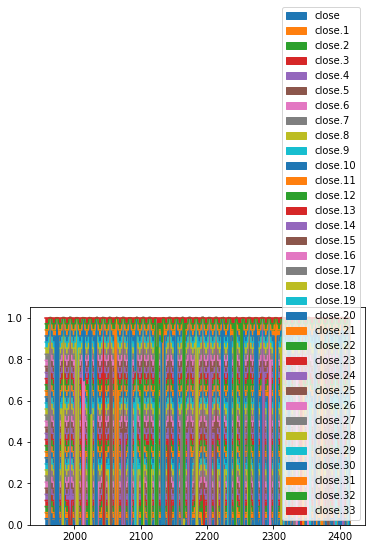

In [200]:
stock_weight.plot(kind="area",legend=True,stacked=True)

In [201]:
purr = [
]

In [202]:
purr

[]

In [203]:
LEN = 10

def avg(data):
    datasum = cnt = 0 
    for num in data:
        datasum += num
        cnt += 1
        if cnt == LEN: 
            yield datasum / LEN
            datasum = cnt = 0 
    if cnt: 
        yield datasum / cnt

print(list(avg(purr)))

[]


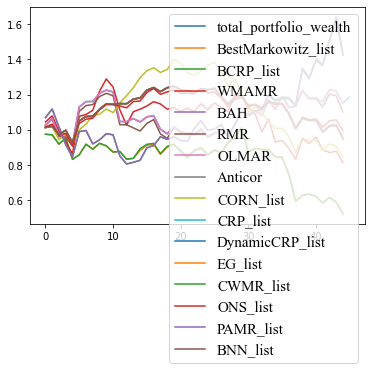

In [204]:
plt.plot(total_portfolio_wealth)
#plt.plot(list(avg(purr)))
plt.plot(BestMarkowitz_list)
plt.plot(BCRP_list)
plt.plot(WMAMR_list)
plt.plot(BAH_list)
plt.plot(RMR_list)
plt.plot(OLMAR_list)
plt.plot(Anticor_list)
plt.plot(CORN_list)
plt.plot(CRP_list)
plt.plot(DynamicCRP_list)
plt.plot(EG_list)
plt.plot(CWMR_list)
plt.plot(ONS_list)
plt.plot(PAMR_list)
plt.plot(BNN_list)
plt.legend(["total_portfolio_wealth","BestMarkowitz_list","BCRP_list","WMAMR","BAH","RMR","OLMAR","Anticor","CORN_list","CRP_list",
           "DynamicCRP_list","EG_list","CWMR_list","ONS_list","PAMR_list","BNN_list"], ncol=1, prop={"family": "Times New Roman", "size": 15})
plt.show()